In [1]:
import os
import theano
import lasagne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer
from lasagne.nonlinearities import softmax
from sklearn.preprocessing import MinMaxScaler, label_binarize

Using gpu device 0: GeForce GTX 860M (CNMeM is disabled)


In [2]:
!pip2 freeze | grep "Theano\|Lasagne\|pandas\|scikit-learn\|matplotlib"

You are using pip version 7.1.2, however version 8.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Lasagne==0.2.dev1
matplotlib==1.4.3
pandas==0.17.0
scikit-learn==0.16.1
Theano==0.7.0


### Open data

In [4]:
import glob

all_files = glob.glob("data/*.txt")
frame = pd.DataFrame()
list_ = []
for file_ in all_files:
    df = pd.read_csv(file_,index_col=None, header=4, sep=';')
    list_.append(df)
frame = pd.concat(list_, axis=0)

In [26]:
frame.columns[:-1]

Index([u'banda 1', u'banda 2', u'banda 3', u'banda 4', u'banda 5', u'banda 7'], dtype='object')

In [6]:
X = frame[frame.columns[:-1]].values
X = X.astype(np.float32)
y = frame[frame.columns[-1]].values
y = y.astype(np.int32)


X_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

print "X_train.shape -> {}, X_test.shape -> {} ".format(X_train.shape,
                                                        X_test.shape)
print "y_train.shape -> {}, y_test.shape -> {} ".format(y_train.shape,
                                                        y_test.shape)
print X.min(), X.max()
print y.min(), y.max()

X_train.shape -> (2099993, 6), X_test.shape -> (899998, 6) 
y_train.shape -> (2099993,), y_test.shape -> (899998,) 
0.0 1.0
0 1


### Network structure

#### Setup all the layers and parameters

In [8]:
layers_0 = [
                (InputLayer, {'shape': (None, 6)}),
                (DenseLayer, {'num_units': 100}),
                (DropoutLayer, {}),
                (DenseLayer, {'num_units': 100}),
                (DenseLayer, {'num_units': 2, 'nonlinearity': softmax}),
        ]

In [9]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

# This class is taken from https://github.com/dnouri/kfkd-tutorial/blob/master/kfkd.py

In [10]:
def create_network(npochs=50, batch_s=10000):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.01)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=False,
        batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.01, stop=0.001),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)
net0 = create_network()

In [185]:
net0.fit(X_train, y_train)

# Neural Network with 11002 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input0         6
  1  dense1       100
  2  dropout2     100
  3  dense3       100
  4  dense4         2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       0.12378       0.02082      5.94641      0.99500  3.56s
      2       0.02108       0.01034      2.03917      0.99673  3.04s
      3       0.01328       0.00745      1.78374      0.99726  2.95s
      4       0.01027       0.00619      1.66068      0.99755  2.94s
      5       0.00878       0.00545      1.60984      0.99780  2.98s
      6       0.00780       0.00501      1.55506      0.99791  2.97s
      7       0.00713       0.00474      1.50495      0.99802  2.95s
      8       0.00665       0.00452      1.47166      0.99811  3.27s
      9       0.00633       0.00438      1.44477      0.99816  3.45s
     10       0.

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f9863bac650>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f97ec4fd490>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 6)}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 100}), (<class 'lasagne.layers.noise.DropoutLayer'>, {}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 100}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 2, 'nonlinearity': <function softmax at 0x7f9877700050>})],
     loss=None, max_epochs=50, more_params={},
     objective=<function objective at 0x7f9863baa500>,
     objective_loss_function=<function categorical_crossentropy at 0x7f98772aede8>,
     on_epoch_finished=[<__main__.AdjustVariable object at 0x7f97ec4fd3d0>, <__main__.AdjustVariable object at 0x7f97ec4fdc10>, <nolearn.lasagne.handlers.PrintLog instance at 0x7f97f4a3e248>],
     on_tra

In [186]:
import cPickle as pickle

with open('data/aguatierra_simpleNN.pickle', 'wb') as f:
        pickle.dump(net0, f, -1)

### Testing of already trained networks

#### Load the best three networks

In [12]:
import cPickle as pickle

net0 = None

fnames_nets = ['data/aguatierra_simpleNN.pickle']
nets = [net0]
for n, fnames in enumerate(fnames_nets):
    with open(fnames, 'rb') as f:
        nets[n] = pickle.load(f)

#### Check structure of the best network *net0*

In [13]:
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()

nets[0].verbose = 3
nets[0].initialize()
layer_info(nets[0])


# Neural Network with 11002 learnable parameters

## Layer information

  #  name        size
---  --------  ------
  0  input0         6
  1  dense1       100
  2  dropout2     100
  3  dense3       100
  4  dense4         2



#### Loss plot of the three networks (valid and train)

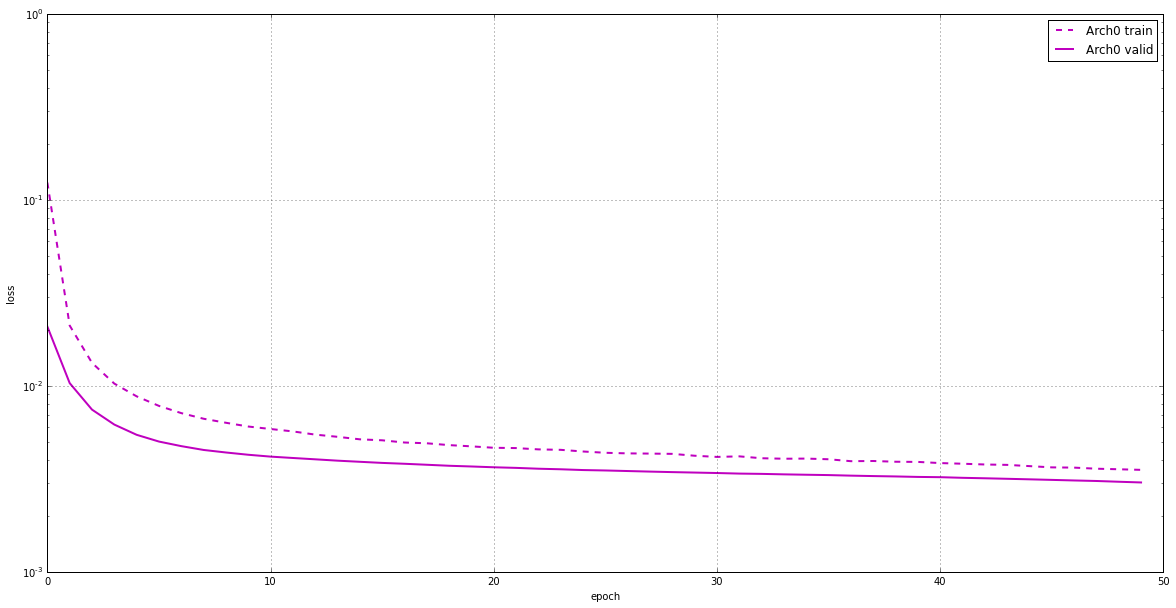

In [14]:
%matplotlib inline

plt.clf()
plt.figure(figsize=(20,10))
for net, net_name, color in zip(nets, ['Arch0'], ['m']):
    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])
    plt.plot(train_loss, '--{}'.format(color), linewidth=2, label="{} train".format(net_name))
    plt.plot(valid_loss, '-{}'.format(color), linewidth=2, label="{} valid".format(net_name))

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.show()

#### Calculate several metrics from sklearn

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc

for net in nets:
    y_pred = net.predict(X_test)
    print classification_report(y_test, y_pred)
    print "[Train dataset] Score: %.5f" % net.score(X_train, y_train)
    print "[Test dataset] Score: %.5f" % net.score(X_test, y_test)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    799800
          1       0.99      1.00      0.99    100198

avg / total       1.00      1.00      1.00    899998

[Train dataset] Score: 0.99874
[Test dataset] Score: 0.99872


In [16]:
def plot_matrix(clf, X_test, y_test, filename):
    """Plot Confussion Matrix from a given classifier"""
    plt.clf()
    plt.imshow(confusion_matrix(y_test, clf.predict(X_test)),
               interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    #save_plot('confusion_matrix_'+str(filename)+'.png')

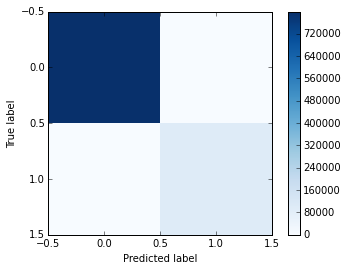

In [17]:
plot_matrix(nets[0], X_test, y_test, 'lero')

In [18]:
confusion_matrix(y_test, nets[0].predict(X_test))

array([[799070,    730],
       [   423,  99775]])

In [21]:
from scipy import interp

def plot_roc_curve(n_classes, y_test, y_score, filename=None):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score.ravel())
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.clf()

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    label = 0
    plt.plot(fpr[label], tpr[label], label='ROC curve of class %d (area = %0.2f)' % (label, roc_auc[label]))
    plt.fill_between(fpr[label], tpr[label], alpha='0.2')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    #plt.clf()
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], 
                label='ROC curve of class {0} (area = {1:0.5f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Only the curve')
    plt.legend(loc="lower right")

1


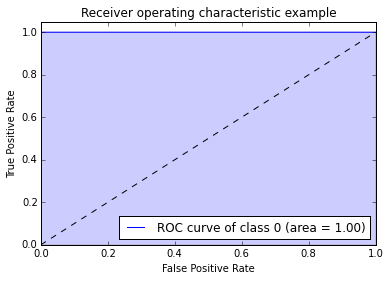

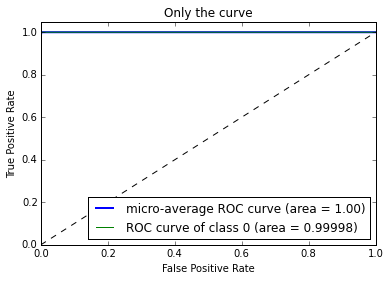

In [22]:
y_score = nets[0].predict_proba(X_test)[:, 1]
y_test_bin = np.array(label_binarize(y_test, classes=np.unique(y)))
n_classes = y_test_bin.shape[1]
print n_classes
plot_roc_curve(n_classes, y_test_bin, y_score, filename='lero')

In [23]:
from sklearn.decomposition import RandomizedPCA # using randomized Singular Value Decomposition 
Xp = RandomizedPCA(n_components=3, random_state=1).fit_transform(X)
Xp

array([[-0.15360342,  0.19812286,  0.205869  ],
       [-0.15545019,  0.18924918,  0.12667079],
       [ 0.08558318,  0.23610364,  0.11428927],
       ..., 
       [-0.49603698,  0.00925441, -0.01638679],
       [-0.39281322,  0.04536371, -0.01268467],
       [-0.40629182,  0.05966967, -0.00508608]])

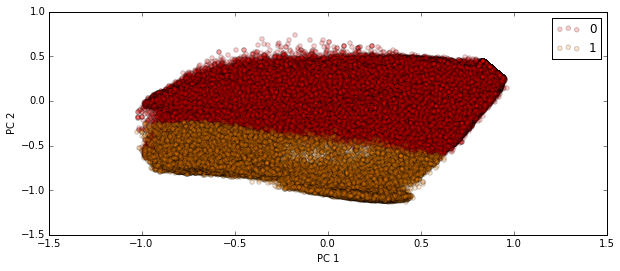

In [24]:
% matplotlib inline
import matplotlib.pyplot as plt

# get the product class 
product_class = np.unique(y)

colors = plt.get_cmap("hsv")

plt.figure(figsize=(10, 4))
for i, p in enumerate(product_class):
    mask = (y == p)
    plt.scatter(Xp[mask, 0], Xp[mask, 1], 
                c=colors(1. * i / 11), label=p, alpha=0.2)
    
plt.legend(loc="best")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
